In [1]:
from datetime import datetime as dt
from arcgis.gis import GIS
gis = GIS('https://ndhagsb01.esri.com/portal', 
          'admin', 
          'esri.agp2', 
          profile="your_enterprise_portal", verify_cert=False)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt

import arcgis
import arcgis.geoanalytics
from arcgis.gis import GIS

from arcgis.geoanalytics.manage_data import run_python_script

In [3]:
import pandas as pd
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import arcgis
arcgis.env.verbose = True

In [ ]:
search_result = gis.content.search("", item_type = "big data file share", max_items=40)
search_result

In [ ]:
air_item = search_result[0]

In [ ]:
air_lyr = air_item.layers[0]

In [ ]:
def data_processsing():
    from datetime import datetime as dt
    import pyspark.sql.functions as F
    from pyspark.sql.functions import concat, col, lit
    # Load the big data file share layer into a DataFrame.
    df = layers[0]
    cols = ['Site Num', 'County Code', 'State Code', 'Date Local', 'Time Local', 'Parameter Name', 'Sample Measurement']
    df = df.select(cols)
    df = df.withColumn('Site_Num', F.lpad(df['Site Num'], 4, '0'))
    df = df.withColumn('County_Code', F.lpad(df['County Code'], 3, '0'))
    df = df.withColumn('State_Code', F.lpad(df['State Code'], 2, '0'))
    df = df.withColumn('unique_id', F.concat(F.col('State_Code'), F.col('County_Code'), F.col('Site_Num')))
#     drop_cols = ['Site_Num', 'County_Code', 'State_Code', 'Site Num', 'County Code', 'State Code']
    df = df.drop('Site_Num', 'County_Code', 'State_Code', 'Site Num', 'County Code', 'State Code')
    df = df.withColumn('datetime', concat(col("Date Local"), lit(" "), col("Time Local")))
#     drop_cols = ['Time Local', 'Date Local']
    df = df.drop('Time Local', 'Date Local')
    df = df.where(col("unique_id") == 300710010)
    # group the dataframe by TextType field and count the number of calls for each call type. 
    df = df.groupby(df['datetime'], df['unique_id']).pivot("Parameter Name").avg("Sample Measurement")

    df.write.format("webgis").save("timeseries_data" + str(dt.now().microsecond))

In [ ]:
run_python_script(code=data_processsing, layers=[air_lyr])

In [5]:
data = gis.content.search('timeseries_data_17_18_19_1station')[0]

In [6]:
series_data = data.tables[0]

In [19]:
df = series_data.query(as_df=True)

In [7]:
def fbprophet():
    from datetime import datetime as dt
    from pyspark.sql.functions import concat, col, lit
    import pandas as pd
    from fbprophet import Prophet
    from pyspark.sql.functions import pandas_udf, PandasUDFType
    from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, FloatType, TimestampType
    import warnings
    warnings.filterwarnings('ignore')
    
    df1 = layers[0]
    cols = ['Outdoor_Temperature', 'Ozone', 'PM10_Total_0_10um_STP',
        'PM2_5___Local_Conditions', 'Relative_Humidity',
        'Wind_Direction___Resultant',
        'Wind_Speed___Resultant', 'datetime']
    df1 = df1.select(cols)
    df1 = df1.withColumn('flag', lit(1))
    schema = StructType([StructField('ds', TimestampType(), True), 
                         StructField('trend', FloatType(), True),
                         StructField('yhat_lower', FloatType(), True),
                         StructField('yhat_upper', FloatType(), True),
                         StructField('trend_lower', FloatType(), True),
                         StructField('trend_upper', FloatType(), True),
                         StructField('PM10_Total_0_10um_STP', FloatType(), True),
                         StructField('PM10_Total_0_10um_STP_lower', FloatType(), True),
                         StructField('PM10_Total_0_10um_STP_upper', FloatType(), True),
                         StructField('Wind_Direction___Resultant', FloatType(), True),
                         StructField('Wind_Direction___Resultant_lower', FloatType(), True),
                         StructField('Wind_Direction___Resultant_upper', FloatType(), True),
                         StructField('Wind_Speed___Resultant', FloatType(), True),
                         StructField('Wind_Speed___Resultant_lower', FloatType(), True),
                         StructField('Wind_Speed___Resultant_upper', FloatType(), True),
                         StructField('additive_terms', FloatType(), True),
                         StructField('additive_terms_lower', FloatType(), True),
                         StructField('additive_terms_upper', FloatType(), True),
                         StructField('daily', FloatType(), True),
                         StructField('daily_lower', FloatType(), True),
                         StructField('daily_upper', FloatType(), True),
                         StructField('extra_regressors_additive', FloatType(), True),
                         StructField('extra_regressors_additive_lower', FloatType(), True),
                         StructField('extra_regressors_additive_upper', FloatType(), True),
                         StructField('weekly', FloatType(), True),
                         StructField('weekly_lower', FloatType(), True),
                         StructField('weekly_upper', FloatType(), True),
                         StructField('multiplicative_terms', FloatType(), True),
                         StructField('multiplicative_terms_lower', FloatType(), True),
                         StructField('multiplicative_terms_upper', FloatType(), True),
                         StructField('yhat', FloatType(), True)])
    @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
    def forecast_pm25(df):
        df['Date'] = df['datetime'].astype('datetime64[ns]')
        df['year'] = df['Date'].dt.year
        df.set_index('Date', inplace=True) 
        df.sort_index(inplace=True)
        v = pd.date_range(start='2016-12-31 23:00:00', periods=18265, freq='H', closed='right')
        newdf = pd.DataFrame(index=v)

        merge=pd.merge(newdf, df, how='left', left_index=True, right_index=True)
        merge.interpolate(method='time', inplace=True)
        merge.reset_index(inplace=True)
        merge.rename(columns={'index': 'ds', 'PM2_5___Local_Conditions': 'y'}, inplace=True)
        merge.interpolate('nearest', inplace=True)
        merge.fillna(0, inplace=True)
        
        for i,item in enumerate(merge['y']):
            if item<=0:
                merge['y'].iloc[i]=merge['y'].iloc[i-1]
            else:
                merge['y'].iloc[i]=item
                
        for i,item in enumerate(merge['PM10_Total_0_10um_STP']):
            if item<=0:
                merge['PM10_Total_0_10um_STP'].iloc[i]=merge['PM10_Total_0_10um_STP'].iloc[i-1]
            else:
                merge['PM10_Total_0_10um_STP'].iloc[i]=item        
         
        for i,item in enumerate(merge['Wind_Speed___Resultant']):
            if item<=0:
                merge['Wind_Speed___Resultant'].iloc[i]=merge['Wind_Speed___Resultant'].iloc[i-1]
            else:
                merge['Wind_Speed___Resultant'].iloc[i]=item
        
        for i,item in enumerate(merge['Wind_Direction___Resultant']):
            if item<=0:
                merge['Wind_Direction___Resultant'].iloc[i]=merge['Wind_Direction___Resultant'].iloc[i-1]
            else:
                merge['Wind_Direction___Resultant'].iloc[i]=item
                
        train_df = merge[merge.year != 2019]
        test_df = merge[merge.year == 2019]
        test_df.drop(columns='y', inplace=True)        
            
        m = Prophet(daily_seasonality=True,
                    weekly_seasonality=True)
        m.add_regressor('PM10_Total_0_10um_STP')
        m.add_regressor('Wind_Speed___Resultant')
        m.add_regressor('Wind_Direction___Resultant')
        m.fit(train_df);
        m.save(r'\\DELDEVD014\store\forecast_model')
        forecast = m.predict(test_df)
        return forecast
    res = df1.groupby(['flag']).apply(forecast_pm25)
#     res.toPandas().to_csv(r'\\DELDEVD014\store\forecast')
    res.write.format("webgis").save("predicted_pm25" + str(dt.now().microsecond))

In [8]:
run_python_script(code=fbprophet, layers=[series_data])

Submitted.
Executing...
Executing (RunPythonScript): RunPythonScript "def fbprophet():\n    from datetime import datetime as dt\n    from pyspark.sql.functions import concat, col, lit\n    import pandas as pd\n    from fbprophet import Prophet\n    from pyspark.sql.functions import pandas_udf, PandasUDFType\n    from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, FloatType, TimestampType\n    import warnings\n    warnings.filterwarnings('ignore')\n    \n    df1 = layers[0]\n    cols = ['Outdoor_Temperature', 'Ozone', 'PM10_Total_0_10um_STP',\n        'PM2_5___Local_Conditions', 'Relative_Humidity',\n        'Wind_Direction___Resultant',\n        'Wind_Speed___Resultant', 'datetime']\n    df1 = df1.select(cols)\n    df1 = df1.withColumn('flag', lit(1))\n    schema = StructType([StructField('ds', TimestampType(), True), \n                         StructField('trend', FloatType(), True),\n                         StructField('yhat_lower', FloatType(), True),\n 

{"messageCode":"BD_101140","message":"An error while executing the Python script: Job aborted due to stage failure: Task 7 in stage 1.0 failed 4 times, most recent failure: Lost task 7.3 in stage 1.0 (TID 57, 10.112.38.34, executor 1): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)\r\n\tat org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$3.applyOrElse(PythonRunner.scala:490)\r\n\tat org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$3.applyOrElse(PythonRunner.scala:479)\r\n\tat scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:36)\r\n\tat org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:178)\r\n\tat org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)\r\n\tat org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)\r\n\tat org.apache.spark.InterruptibleIterator.hasNext(Inte

Failed to execute (RunPythonScript).


Failed to execute (RunPythonScript).


Failed at Mon Mar 30 23:45:59 2020 (Elapsed Time: 1 minutes 11 seconds)
Failed.


Failed.


Exception: Job failed.

In [ ]:
from pyspark.sql.functions import current_date

results = (
    store_item_history
    .groupBy('store', 'item')
    .apply(forecast_store_item)
    .withColumn('training_date', current_date())
    )

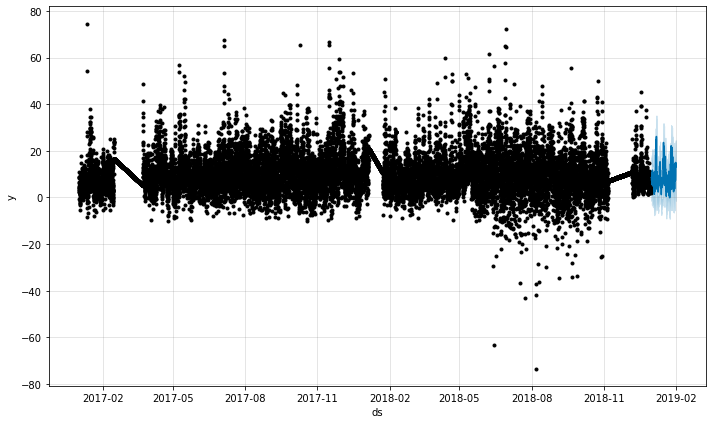

In [76]:
m.plot(forecast);

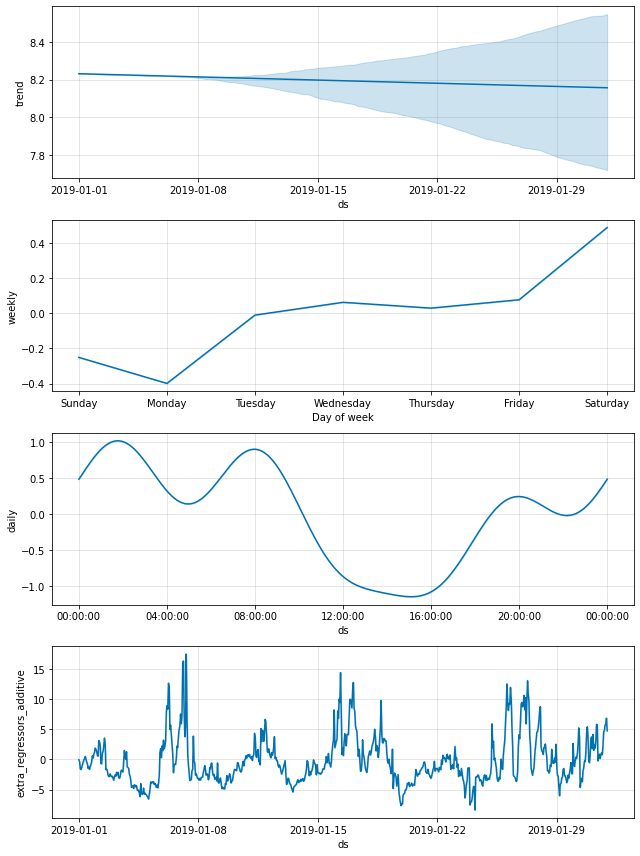

In [77]:
m.plot_components(forecast);

In [78]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [84]:
merge.reset_index(inplace=True)

In [85]:
merge.rename(columns={'index': 'ds', 'PM2_5___Local_Conditions': 'y'}, inplace=True)

In [86]:
cmp_df = make_comparison_dataframe(merge, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,Outdoor_Temperature,Ozone,PM10_Total_0_10um_STP,y,Relative_Humidity,Wind_Direction___Resultant,Wind_Speed___Resultant,datetime,year
ds,,,,,,,,,,,,
2019-01-31 21:00:00,14.138108,6.211571,22.620274,38.8,0.002,29.3,13.6,67.0,40.0,1.4,2019-01-31 21:00,2019.0
2019-01-31 22:00:00,15.040073,6.604654,24.558288,37.8,0.001,32.4,15.0,70.0,39.0,1.6,2019-01-31 22:00,2019.0
2019-01-31 23:00:00,13.056575,3.940501,22.072881,35.8,0.001,27.4,15.2,80.0,105.0,1.3,2019-01-31 23:00,2019.0


In [94]:
len(test_df)

744

In [87]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}


In [88]:
prediction_size=30

In [95]:
for err_name, err_value in calculate_forecast_errors(cmp_df, len(test_df)).items():
    print(err_name, err_value)

MAPE 27.951419645276836
MAE 2.443615064067962


In [91]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [93]:
cmp_df

,yhat,yhat_lower,yhat_upper,Outdoor_Temperature,Ozone,PM10_Total_0_10um_STP,y,Relative_Humidity,Wind_Direction___Resultant,Wind_Speed___Resultant,datetime,year
ds,,,,,,,,,,,,
2019-01-01 00:00:00,8.647127,-0.380424,17.110997,60.4,0.017,15.5,5.5,99.0,210.0,1.1,2019-01-01 00:00,2019.0
2019-01-01 01:00:00,8.772300,0.132942,17.179572,60.1,0.012,16.0,5.7,99.0,269.0,1.3,2019-01-01 01:00,2019.0
2019-01-01 02:00:00,7.660686,-1.088984,16.013952,59.7,0.018,13.9,5.4,99.0,287.0,2.6,2019-01-01 02:00,2019.0
2019-01-01 03:00:00,7.281887,-0.974200,16.114080,58.1,0.024,10.1,4.4,99.0,153.0,1.6,2019-01-01 03:00,2019.0
2019-01-01 04:00:00,7.236234,-1.488255,15.776158,57.0,0.022,10.9,4.4,99.0,178.0,0.7,2019-01-01 04:00,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31 19:00:00,13.018689,3.559850,21.903453,43.2,0.003,26.6,9.9,48.0,78.0,0.9,2019-01-31 19:00,2019.0
2019-01-31 20:00:00,14.157121,5.677876,22.482329,40.8,0.002,29.9,10.5,59.0,70.0,1.7,2019-01-31 20:00,2019.0
2019-01-31 21:00:00,14.138108,6.211571,22.620274,38.8,0.002,29.3,13.6,67.0,40.0,1.4,2019-01-31 21:00,2019.0


In [98]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='pm2.5'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, len(test_df), len(test_df), 'pm 25 prediction in 2019')